# Notebook for the Capstone Project

## Outline

1.	Installation of the necessary libraries/ modules
2.	Collection of the geodetic coordinates and Data Cleaning
3.	Data Visualisation
4.	Data Collection from APIs and Data Preparation
5.  Analyze Each Neighborhood
6.	Clustering and visualisation of the Result

## 1. Installation of the necessary libraries/ modules

In [5]:
!pip install folium==0.5.0

     |████████████████████████████████| 81kB 9.8MB/s  eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium


In [3]:
!pip install geocoder

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2.	Collection of the geodetic coordinates and Data Cleaning

#### The data are downlouded from Wikipedia.

In [7]:
df = pd.read_html('https://de.wikipedia.org/wiki/Liste_der_Stationen_der_S-Bahn_Berlin')[0]
df.head()

,S-Bahnhof(ehem. Name),Strecke,Linie(n),Lage,Aufnahme,Einstellung,Unnamed: 6,Unnamed: 7,Bemerkungen,Bild
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,NaN,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...",06. Nov. 1928,NaN,NaN,NaN,NaN,NaN
1,Ahrensfelde,Wriezener Bahn,NaN,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...",NaN,NaN,×,NaN,NaN,NaN
2,Albrechtshof,Hamburger Bahn,NaN,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O",NaN,09. Okt. 1961,NaN,NaN,NaN,NaN
3,Alexanderplatz,Stadtbahn,NaN,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",NaN,NaN,×,×,NaN,NaN
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,NaN,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...",NaN,09. Jan. 1984,NaN,NaN,NaN,NaN


#### Deleting of the unnecessary Columns 

In [8]:
df.drop(['Linie(n)'], axis=1, inplace=True)
df.drop(['Aufnahme'], axis=1, inplace=True)
df.drop(['Einstellung'], axis=1, inplace=True)
df.drop( ['Unnamed: 6'], axis=1, inplace=True)
df.drop(['Unnamed: 7'], axis=1, inplace=True)
df.drop(['Bemerkungen'], axis=1, inplace=True)
df.drop(['Bild'], axis=1, inplace=True)
df.head()

,S-Bahnhof(ehem. Name),Strecke,Lage
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3..."
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°..."
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O"
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O"
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°..."


#### Translations of the column names from German to English.

In [9]:
df.rename(columns={'S-Bahnhof(ehem. Name)':'Station Name', 'Strecke':'Line', 'Lage':'Neighborhood'}, inplace=True)
df.head()

,Station Name,Line,Neighborhood
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3..."
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°..."
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O"
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O"
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°..."


#### Separating the coordinates from the Neighborhood column.

In [10]:
df['coordinates'] = df['Neighborhood'].astype('str')

In [11]:
for i in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYT()″-öäü":
    df['coordinates'] = df['coordinates'].str.replace('{}'.format(i),'')
df['coordinates'] = df['coordinates'].str.replace('°','.')
df['coordinates'] = df['coordinates'].str.replace(' ','')
df.head()

,Station Name,Line,Neighborhood,coordinates
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...","52. 26′ 5 ,13. 32′ 29"
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...","52. 34′ 18 ,13. 33′ 54"
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O","52. 32′ 58 ,13. 7′ 42"
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O","52. 31′ 17 ,13. 24′ 43"
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...","52. 34′ 40 ,13. 21′ 2"


#### Seperating the minutes and seconds of the coodinates to transform them to a format that is supported bei thre API

In [12]:
df[['lon','lat']] = df.coordinates.str.split(",",expand=True)
df.head()

,Station Name,Line,Neighborhood,coordinates,lon,lat
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...","52. 26′ 5 ,13. 32′ 29",52. 26′ 5,13. 32′ 29
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...","52. 34′ 18 ,13. 33′ 54",52. 34′ 18,13. 33′ 54
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O","52. 32′ 58 ,13. 7′ 42",52. 32′ 58,13. 7′ 42
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O","52. 31′ 17 ,13. 24′ 43",52. 31′ 17,13. 24′ 43
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...","52. 34′ 40 ,13. 21′ 2",52. 34′ 40,13. 21′ 2


In [13]:
df[['lon1','lon2']] = df.lon.str.split(".",expand=True)
df[['lat1','lat2']] = df.lat.str.split(".",expand=True)
df.head()

,Station Name,Line,Neighborhood,coordinates,lon,lat,lon1,lon2,lat1,lat2
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...","52. 26′ 5 ,13. 32′ 29",52. 26′ 5,13. 32′ 29,52,26′ 5,13,32′ 29
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...","52. 34′ 18 ,13. 33′ 54",52. 34′ 18,13. 33′ 54,52,34′ 18,13,33′ 54
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O","52. 32′ 58 ,13. 7′ 42",52. 32′ 58,13. 7′ 42,52,32′ 58,13,7′ 42
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O","52. 31′ 17 ,13. 24′ 43",52. 31′ 17,13. 24′ 43,52,31′ 17,13,24′ 43
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...","52. 34′ 40 ,13. 21′ 2",52. 34′ 40,13. 21′ 2,52,34′ 40,13,21′ 2


In [14]:
df[['lon21','lon22']] = df.lon2.str.split("′",expand=True)
df[['lat21','lat22']] = df.lat2.str.split("′",expand=True)
df.head()

,Station Name,Line,Neighborhood,coordinates,lon,lat,lon1,lon2,lat1,lat2,lon21,lon22,lat21,lat22
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...","52. 26′ 5 ,13. 32′ 29",52. 26′ 5,13. 32′ 29,52,26′ 5,13,32′ 29,26,5,32,29
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...","52. 34′ 18 ,13. 33′ 54",52. 34′ 18,13. 33′ 54,52,34′ 18,13,33′ 54,34,18,33,54
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O","52. 32′ 58 ,13. 7′ 42",52. 32′ 58,13. 7′ 42,52,32′ 58,13,7′ 42,32,58,7,42
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O","52. 31′ 17 ,13. 24′ 43",52. 31′ 17,13. 24′ 43,52,31′ 17,13,24′ 43,31,17,24,43
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...","52. 34′ 40 ,13. 21′ 2",52. 34′ 40,13. 21′ 2,52,34′ 40,13,21′ 2,34,40,21,2


In [15]:
df['lon21'] = df['lon21'].str.strip()
df['lon22'] = df['lon22'].str.strip()
df['lat21'] = df['lat21'].str.strip()
df['lat22'] = df['lat22'].str.strip()

#### Transformation of the coordinates from String to float

In [16]:
df['lon1']=pd.to_numeric(df['lon1'], errors='coerce')
df['lat1']=pd.to_numeric(df['lat1'], errors='coerce')
df['lon21']=pd.to_numeric(df['lon21'], errors='coerce')
df['lon22']=pd.to_numeric(df['lon22'], errors='coerce')
df['lat21']=pd.to_numeric(df['lat21'], errors='coerce')
df['lat22']=pd.to_numeric(df['lat22'], errors='coerce')

In [16]:
df.head()

,Station Name,Line,Neighborhood,coordinates,lon,lat,lon1,lon2,lat1,lat2,lon21,lon22,lat21,lat22
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...","52. 26′ 5 ,13. 32′ 29",52. 26′ 5,13. 32′ 29,52.0,26′ 5,13.0,32′ 29,26.0,5.0,32.0,29.0
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...","52. 34′ 18 ,13. 33′ 54",52. 34′ 18,13. 33′ 54,52.0,34′ 18,13.0,33′ 54,34.0,18.0,33.0,54.0
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O","52. 32′ 58 ,13. 7′ 42",52. 32′ 58,13. 7′ 42,52.0,32′ 58,13.0,7′ 42,32.0,58.0,7.0,42.0
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O","52. 31′ 17 ,13. 24′ 43",52. 31′ 17,13. 24′ 43,52.0,31′ 17,13.0,24′ 43,31.0,17.0,24.0,43.0
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...","52. 34′ 40 ,13. 21′ 2",52. 34′ 40,13. 21′ 2,52.0,34′ 40,13.0,21′ 2,34.0,40.0,21.0,2.0


#### Calculation of the longitude and latitude values and deleting of the columns, that were created for the separation and the calculation.

In [17]:
df['lon']=df['lon1']+(df['lon21']+df['lon22']/60)/60
df['lat']=df['lat1']+(df['lat21']+df['lat22']/60)/60
df.drop(['lon1'], axis=1, inplace=True)
df.drop(['lon2'], axis=1, inplace=True)
df.drop(['lat1'], axis=1, inplace=True)
df.drop( ['lat2'], axis=1, inplace=True)
df.drop(['lon21','lon22','lon22','lat21','lat22','coordinates'], axis=1, inplace=True)


df.head()

,Station Name,Line,Neighborhood,lon,lat
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...",52.434722,13.541389
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...",52.571667,13.565000
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O",52.549444,13.128333
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",52.521389,13.411944
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...",52.577778,13.350556


In [18]:
df.shape

(193, 5)

#### Deleting of all lines that do not contain values eigher in the longitude ir in the latitude column

In [18]:
df.dropna(subset=['lon'],axis=0, inplace=True)
df.dropna(subset=['lat'],axis=0, inplace=True)
df.shape

(157, 5)

In [50]:
df.reset_index(inplace=True, drop=True)
df.head()

,Station Name,Line,Neighborhood,lon,lat
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...",52.434722,13.541389
1,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...",52.571667,13.565000
2,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O",52.549444,13.128333
3,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",52.521389,13.411944
4,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...",52.577778,13.350556


## 3. Data Visualisation

#### Visualisation of all the collected stations

In [41]:
# add markers to map
map_berlin = folium.Map(location=[52.521918, 13.413215], zoom_start=11)
for lat, lng, borough in zip(df['lon'],df['lat'], df['Station Name']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

## 4. Data Collection from APIs and Data Preparation

#### Define Foursquare Credentials and Version

In [21]:
CLIENT_ID = '1V1EF5C5NSJOSL2LEJKMKTLHI1KPAHAGS41QR32LNBJPELNC' # your Foursquare ID
CLIENT_SECRET = 'UPW23RJR4UJSAXCK1RQ3LH4K4PJU1RXBLT1FDFO0GHU4LC3S' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
categorylist=('4d4b7104d754a06370d81259','4d4b7105d754a06372d81259','4d4b7105d754a06373d81259','4d4b7105d754a06374d81259',
              '4d4b7105d754a06376d81259','4d4b7105d754a06377d81259','4d4b7105d754a06375d81259','4e67e38e036454776db1fb3a',
              '4d4b7105d754a06378d81259','4d4b7105d754a06379d81259')

Your credentails:
CLIENT_ID: 1V1EF5C5NSJOSL2LEJKMKTLHI1KPAHAGS41QR32LNBJPELNC
CLIENT_SECRET:UPW23RJR4UJSAXCK1RQ3LH4K4PJU1RXBLT1FDFO0GHU4LC3S


#### Let's create a function to repeat the same process of collection data from the foursquare API to all the stations of Berlin

Get all venues in a radius of 1000m divided into the following categories:

| Category code for the API request | category |
| --- | --- |
| 4d4b7104d754a06370d81259 | Arts & Entertainment |
| 4d4b7105d754a06372d81259 | College & University |
| 4d4b7105d754a06373d81259' | Event |
| 4d4b7105d754a06374d81259 | Food |
| 4d4b7105d754a06376d81259 | Nightlife Spot |
| 4d4b7105d754a06377d81259 | Outdoors & Recreation | 
| 4d4b7105d754a06375d81259 | Professional & Other Places |
| 4e67e38e036454776db1fb3a | Residence |
| 4d4b7105d754a06378d81259 | Shop & Service |
| 4d4b7105d754a06379d81259 | Travel & Transport |

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        for category in categorylist:    
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit=100'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                category)
            
        # make the GET request
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'],  
                    category) for v in results])
            except:
                print('error')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station Name', 
                  'Station Latitude', 
                  'Station Name Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

#### Use the function to get the venues around every station

In [23]:
berlin_venues2 = getNearbyVenues(names=df['Station Name'],
                                   latitudes=df['lon'],
                                   longitudes=df['lat']
                                  )

Adlershof(bis 1935 Adlershof=Alt-Glienicke)
Ahrensfelde
Albrechtshof
Alexanderplatz
Alt-Reinickendorf(bis 1994 Reinickendorf)
Altglienicke
Anhalter Bahnhof
Attilastraße(bis 1992 Mariendorf)
Babelsberg(bis 1938 Nowawes)
Baumschulenweg
Bellevue
Bergfelde (b Berlin)
Bernau (b Berlin)
Bernau-Friedenstal
Betriebsbahnhof Rummelsburg
Betriebsbahnhof Schöneweide(bis 1945 Betriebshaltepunkt Niederschöneweide)
Beusselstraße
Biesdorf
Birkenstein
Birkenwerder (b Berlin)
Blankenburg
Blankenfelde (Kr Teltow-Fläming)
Borgsdorf
Bornholmer Straße
Brandenburger Tor(bis 2009 Unter den Linden)
Buch
Buckower Chaussee
Bundesplatz(bis 1938 Wilmersdorf-Friedenau)(1938–1993 Wilmersdorf)
Charlottenburg
Dahlewitz
Dreilinden
Eichborndamm(bis 1994 Eichbornstraße)
Eichkamp
Eichwalde(bis 1953 Eichwalde [Kr Teltow])
Erkner
Falkensee
Flughafen Berlin-Brandenburg
Flughafen Berlin-Schönefeld(bis 1976 Zentralflughafen Berlin-Schönefeld)
Frankfurter Allee(1949–1961 Stalinallee)
Fredersdorf (b Berlin)
Friedenau
Friedrichsf

#### Let's check the size of the resulting datafram

In [24]:
print(berlin_venues2.shape)
berlin_venues2.head()

(21350, 5)


,Station Name,Station Latitude,Station Name Longitude,Venue,Venue Category
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),52.434722,13.541389,Theater Adlershof,4d4b7104d754a06370d81259
1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),52.434722,13.541389,Anna-Seghers-Gedenkstätte,4d4b7104d754a06370d81259
2,Adlershof(bis 1935 Adlershof=Alt-Glienicke),52.434722,13.541389,Casablanca,4d4b7104d754a06370d81259
3,Adlershof(bis 1935 Adlershof=Alt-Glienicke),52.434722,13.541389,Galerie Alte Schule,4d4b7104d754a06370d81259
4,Adlershof(bis 1935 Adlershof=Alt-Glienicke),52.434722,13.541389,Institut für Physik / Lise-Meitner-Haus (Humbo...,4d4b7105d754a06372d81259


#### Let's check how many venues were returned for each neighborhood

In [25]:
berlin_venues2.groupby('Station Name').count()

,Station Latitude,Station Name Longitude,Venue,Venue Category
Station Name,,,,
Adlershof(bis 1935 Adlershof=Alt-Glienicke),130,130,130,130
Ahrensfelde,51,51,51,51
Albrechtshof,16,16,16,16
Alexanderplatz,599,599,599,599
Alt-Reinickendorf(bis 1994 Reinickendorf),59,59,59,59
Altglienicke,33,33,33,33
Anhalter Bahnhof,517,517,517,517
Attilastraße(bis 1992 Mariendorf),39,39,39,39
Babelsberg(bis 1938 Nowawes),112,112,112,112


#### Let's find out how many unique categories can be curated from all the returned venues

In [26]:
print('There are {} uniques categories.'.format(len(berlin_venues2['Venue Category'].unique())))


There are 10 uniques categories.


## 5. Analyze Each Neighborhood

In [27]:
# one hot encoding for every category
berlin_onehot = pd.get_dummies(berlin_venues2[['Venue Category']], prefix="", prefix_sep="")

# add station column back to dataframe
berlin_onehot['Station Name'] = berlin_venues2['Station Name'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

,Station Name,4d4b7104d754a06370d81259,4d4b7105d754a06372d81259,4d4b7105d754a06373d81259,4d4b7105d754a06374d81259,4d4b7105d754a06375d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259,4d4b7105d754a06379d81259,4e67e38e036454776db1fb3a
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),1,0,0,0,0,0,0,0,0,0
1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),1,0,0,0,0,0,0,0,0,0
2,Adlershof(bis 1935 Adlershof=Alt-Glienicke),1,0,0,0,0,0,0,0,0,0
3,Adlershof(bis 1935 Adlershof=Alt-Glienicke),1,0,0,0,0,0,0,0,0,0
4,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0,1,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and count the occurrence of each category, change the column names from the code to the real names for a better understanding

In [86]:
berlin_grouped = berlin_onehot.groupby('Station Name').sum().reset_index()
berlin_grouped.rename(columns={'4d4b7104d754a06370d81259':'Arts & Entertainment','4d4b7105d754a06372d81259':'College & University','4d4b7105d754a06373d81259':'Event',
'4d4b7105d754a06374d81259':'Food','4d4b7105d754a06376d81259':'Nightlife Spot','4d4b7105d754a06377d81259':'Outdoors & Recreation','4d4b7105d754a06375d81259':'Professional & Other Places','4e67e38e036454776db1fb3a':'Residence','4d4b7105d754a06378d81259':'Shop & Service','4d4b7105d754a06379d81259':'Travel & Transport'}, inplace=True)
berlin_grouped.head()

,Station Name,Arts & Entertainment,College & University,Event,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),4,11,0,25,35,5,5,30,13,2
1,Ahrensfelde,0,4,0,4,10,4,9,14,4,2
2,Albrechtshof,0,1,0,4,3,0,4,2,2,0
3,Alexanderplatz,60,22,8,100,72,70,64,92,100,11
4,Alt-Reinickendorf(bis 1994 Reinickendorf),1,7,0,6,14,2,8,11,7,3


#### Let’s display the number of venues as boxplots 

[Text(0, 0, 'Arts & Entertainment'),
 Text(0, 0, 'College & University'),
 Text(0, 0, 'Event'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Professional & Other Places'),
 Text(0, 0, 'Nightlife Spot'),
 Text(0, 0, 'Outdoors & Recreation'),
 Text(0, 0, 'Shop & Service'),
 Text(0, 0, 'Travel & Transport'),
 Text(0, 0, 'Residence')]

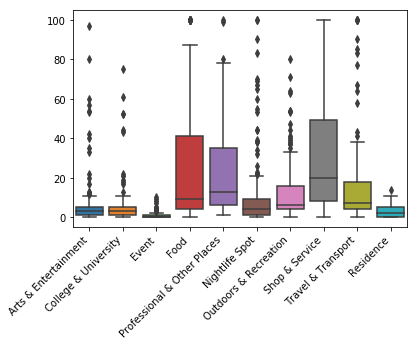

In [40]:
import seaborn as sns
ax=sns.boxplot(data=berlin_grouped)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')

#### Let’s normalize the data using min-max scaling 

In [87]:
berlin_grouped['Arts & Entertainment']=berlin_grouped['Arts & Entertainment']/berlin_grouped['Arts & Entertainment'].max()
berlin_grouped['College & University']=berlin_grouped['College & University']/berlin_grouped['College & University'].max()
berlin_grouped.drop(['Event'], axis=1, inplace=True)
berlin_grouped['Food']=berlin_grouped['Food']/berlin_grouped['Food'].max()
berlin_grouped['Professional & Other Places']=berlin_grouped['Professional & Other Places']/berlin_grouped['Professional & Other Places'].max()
berlin_grouped['Nightlife Spot']=berlin_grouped['Nightlife Spot']/berlin_grouped['Nightlife Spot'].max()
berlin_grouped['Outdoors & Recreation']=berlin_grouped['Outdoors & Recreation']/berlin_grouped['Outdoors & Recreation'].max()
berlin_grouped['Shop & Service']=berlin_grouped['Shop & Service']/berlin_grouped['Shop & Service'].max()
berlin_grouped['Travel & Transport']=berlin_grouped['Travel & Transport']/berlin_grouped['Travel & Transport'].max()
berlin_grouped['Residence']=berlin_grouped['Residence']/berlin_grouped['Residence'].max()


In [88]:
berlin_grouped2=berlin_grouped.copy()
berlin_grouped.head()

,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence
0,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0.041237,0.146667,0.25,0.35,0.05,0.0625,0.30,0.13,0.142857
1,Ahrensfelde,0.000000,0.053333,0.04,0.10,0.04,0.1125,0.14,0.04,0.142857
2,Albrechtshof,0.000000,0.013333,0.04,0.03,0.00,0.0500,0.02,0.02,0.000000
3,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714
4,Alt-Reinickendorf(bis 1994 Reinickendorf),0.010309,0.093333,0.06,0.14,0.02,0.1000,0.11,0.07,0.214286


[Text(0, 0, 'Arts & Entertainment'),
 Text(0, 0, 'College & University'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Professional & Other Places'),
 Text(0, 0, 'Nightlife Spot'),
 Text(0, 0, 'Outdoors & Recreation'),
 Text(0, 0, 'Shop & Service'),
 Text(0, 0, 'Travel & Transport'),
 Text(0, 0, 'Residence')]

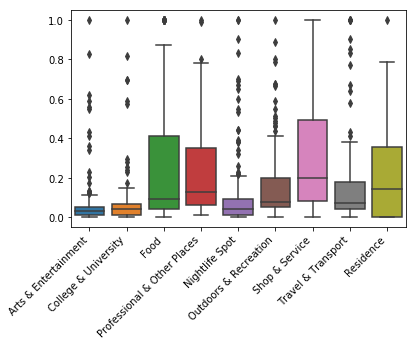

In [44]:
ax=sns.boxplot(data=berlin_grouped2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')

## 6. Clustering and visualisation of the Result

#### Run k-means to cluster the neighborhood into 2 clusters

In [45]:
kclusters = 2

berlin_grouped_clustering = berlin_grouped.drop('Station Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int32)

In [46]:
# add clustering labels
berlin_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
berlin_grouped.head()


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence
0,1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0.041237,0.146667,0.25,0.35,0.05,0.0625,0.30,0.13,0.142857
1,1,Ahrensfelde,0.000000,0.053333,0.04,0.10,0.04,0.1125,0.14,0.04,0.142857
2,1,Albrechtshof,0.000000,0.013333,0.04,0.03,0.00,0.0500,0.02,0.02,0.000000
3,0,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714
4,1,Alt-Reinickendorf(bis 1994 Reinickendorf),0.010309,0.093333,0.06,0.14,0.02,0.1000,0.11,0.07,0.214286


#### Let's create a new dataframe that includes the cluster as well as the percentage value for the number of occurrences of every categroy

In [47]:
berlin_merged1 = berlin_grouped
berlin_merged1.set_index('Station Name')
berlin_merged2=df
berlin_merged2.set_index('Station Name')
print(berlin_merged1.shape,berlin_merged2.shape)

(157, 11) (157, 5)


In [51]:
result=pd.concat([berlin_merged1, berlin_merged2], axis=1, join='inner')
print(result.shape)
result.reset_index(inplace=True, drop=True)
result.head()

(157, 16)


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,Station Name,Line,Neighborhood,lon,lat
0,1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0.041237,0.146667,0.25,0.35,0.05,0.0625,0.30,0.13,0.142857,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...",52.434722,13.541389
1,1,Ahrensfelde,0.000000,0.053333,0.04,0.10,0.04,0.1125,0.14,0.04,0.142857,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...",52.571667,13.565000
2,1,Albrechtshof,0.000000,0.013333,0.04,0.03,0.00,0.0500,0.02,0.02,0.000000,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O",52.549444,13.128333
3,0,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",52.521389,13.411944
4,1,Alt-Reinickendorf(bis 1994 Reinickendorf),0.010309,0.093333,0.06,0.14,0.02,0.1000,0.11,0.07,0.214286,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...",52.577778,13.350556


#### Visualize every station with the associated cluster

In [98]:
f = folium.Figure(width=500, height=500)
map_clusters = folium.Map(location=[52.521918, 13.413215], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(result['lon'], result['lat'], result['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
f.add_child(map_clusters)
f

#### Run k-means to cluster the stations into 4 clusters

In [89]:
kclusters2 = 3

berlin_grouped_clustering = berlin_grouped.drop('Station Name', 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10] 

array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1], dtype=int32)

In [90]:
# add clustering labels
berlin_grouped2.insert(0, 'Cluster Labels', kmeans2.labels_)
berlin_grouped2.head()

,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence
0,1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0.041237,0.146667,0.25,0.35,0.05,0.0625,0.30,0.13,0.142857
1,1,Ahrensfelde,0.000000,0.053333,0.04,0.10,0.04,0.1125,0.14,0.04,0.142857
2,1,Albrechtshof,0.000000,0.013333,0.04,0.03,0.00,0.0500,0.02,0.02,0.000000
3,2,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714
4,1,Alt-Reinickendorf(bis 1994 Reinickendorf),0.010309,0.093333,0.06,0.14,0.02,0.1000,0.11,0.07,0.214286


#### Let's create a new dataframe that includes the cluster as well as the percentage value for the number of occurrences of every categroy

In [91]:
berlin_merged11 = berlin_grouped2
berlin_merged11.set_index('Station Name')
berlin_merged2=df
berlin_merged2.set_index('Station Name')
print(berlin_merged11.shape,berlin_merged2.shape)

(157, 11) (157, 5)


In [92]:
result2=pd.concat([berlin_merged11, berlin_merged2], axis=1, join='inner')
print(result2.shape)
result2.reset_index(inplace=True, drop=True)
result2

(157, 16)


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,Station Name,Line,Neighborhood,lon,lat
0,1,Adlershof(bis 1935 Adlershof=Alt-Glienicke),0.041237,0.146667,0.25,0.35,0.05,0.0625,0.30,0.13,0.142857,Adlershof(bis 1935 Adlershof=Alt-Glienicke),Görlitzer Bahn,"Adlershof(Treptow-Köpenick)52° 26′ 5″ N, 13° 3...",52.434722,13.541389
1,1,Ahrensfelde,0.000000,0.053333,0.04,0.10,0.04,0.1125,0.14,0.04,0.142857,Ahrensfelde,Wriezener Bahn,"Marzahn(Marzahn-Hellersdorf)52° 34′ 18″ N, 13°...",52.571667,13.565000
2,1,Albrechtshof,0.000000,0.013333,0.04,0.03,0.00,0.0500,0.02,0.02,0.000000,Albrechtshof,Hamburger Bahn,"Staaken(Spandau)52° 32′ 58″ N, 13° 7′ 42″ O",52.549444,13.128333
3,2,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",52.521389,13.411944
4,1,Alt-Reinickendorf(bis 1994 Reinickendorf),0.010309,0.093333,0.06,0.14,0.02,0.1000,0.11,0.07,0.214286,Alt-Reinickendorf(bis 1994 Reinickendorf),Kremmener Bahn,"Reinickendorf(Reinickendorf)52° 34′ 40″ N, 13°...",52.577778,13.350556
5,1,Altglienicke,0.010309,0.000000,0.04,0.10,0.00,0.0750,0.05,0.04,0.214286,Altglienicke,Grünauer Kreuz–BER,"Altglienicke(Treptow-Köpenick)52° 24′ 26″ N, 1...",52.407222,13.558889
6,2,Anhalter Bahnhof,0.432990,0.240000,1.00,0.78,0.39,0.6750,0.92,0.85,0.357143,Anhalter Bahnhof,Anhalter BahnDresdener BahnNord-Süd-Tunnel,Kreuzberg(Friedrichshain-Kreuzberg)52° 30′ 11″...,52.503056,13.381944
7,1,Attilastraße(bis 1992 Mariendorf),0.010309,0.026667,0.05,0.07,0.01,0.0500,0.11,0.08,0.000000,Attilastraße(bis 1992 Mariendorf),Dresdener Bahn,"Tempelhof(Tempelhof-Schöneberg)52° 26′ 52″ N, ...",52.447778,13.360833
8,1,Babelsberg(bis 1938 Nowawes),0.041237,0.026667,0.28,0.16,0.05,0.0250,0.39,0.12,0.285714,Babelsberg(bis 1938 Nowawes),Wannseebahn,"Babelsberg(Potsdam)52° 23′ 29″ N, 13° 5′ 32″ O",52.391389,13.092222
9,1,Baumschulenweg,0.000000,0.040000,0.13,0.09,0.08,0.0750,0.22,0.11,0.214286,Baumschulenweg,Görlitzer BahnVerbindungsbahn Baumschulenweg–N...,"Baumschulenweg(Treptow-Köpenick)52° 28′ 3″ N, ...",52.467500,13.489722


#### Visualize every station with the associated cluster

In [93]:
f = folium.Figure(width=500, height=500)
map_clusters = folium.Map(location=[52.521918, 13.413215], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters2)
ys = [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(result2['lon'], result2['lat'], result2['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
f.add_child(map_clusters)
f

### Examine Clusters

#### Cluster 0 (red)

In [94]:
print(result2.loc[result2['Cluster Labels']==0].shape)
result2.loc[result2['Cluster Labels']==0]


(39, 16)


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,Station Name,Line,Neighborhood,lon,lat
10,0,Bellevue,0.072165,0.053333,0.53,0.36,0.13,0.5125,0.49,0.34,0.214286,Bellevue,Stadtbahn,"Hansaviertel(Mitte)52° 31′ 12″ N, 13° 20′ 52″ O",52.520000,13.347778
16,0,Beusselstraße,0.061856,0.053333,0.53,0.35,0.10,0.1000,0.49,0.14,0.071429,Beusselstraße,Ringbahn,"Moabit(Mitte)52° 32′ 4″ N, 13° 19′ 46″ O",52.534444,13.329444
23,0,Bornholmer Straße,0.030928,0.133333,0.72,0.32,0.18,0.2625,0.65,0.27,0.500000,Bornholmer Straße,NordbahnStettiner Bahn,"Prenzlauer Berg(Pankow)52° 33′ 16″ N, 13° 23′ ...",52.554444,13.398056
27,0,Bundesplatz(bis 1938 Wilmersdorf-Friedenau)(19...,0.072165,0.053333,0.60,0.51,0.13,0.3000,0.50,0.22,0.285714,Bundesplatz(bis 1938 Wilmersdorf-Friedenau)(19...,Ringbahn,Wilmersdorf(Tempelhof-Schöneberg)52° 28′ 39″ N...,52.477500,13.328611
38,0,Frankfurter Allee(1949–1961 Stalinallee),0.082474,0.120000,1.00,0.56,0.38,0.4125,0.86,0.33,0.428571,Frankfurter Allee(1949–1961 Stalinallee),Ringbahn,Friedrichshain(Friedrichshain-Kreuzberg)52° 30...,52.515000,13.474167
40,0,Friedenau,0.041237,0.066667,0.52,0.46,0.11,0.2125,0.52,0.21,0.571429,Friedenau,Wannseebahn,"Schöneberg(Tempelhof-Schöneberg)52° 28′ 12″ N,...",52.470000,13.340556
47,0,Gesundbrunnen,0.041237,0.053333,0.55,0.47,0.16,0.3375,0.73,0.29,0.642857,Gesundbrunnen,RingbahnStettiner Bahn,"Gesundbrunnen(Mitte)52° 32′ 55″ N, 13° 23′ 22″ O",52.548611,13.389444
48,0,Greifswalder Straße(bis 1946 Weißensee)(1986–1...,0.103093,0.080000,0.38,0.29,0.08,0.2500,0.54,0.14,0.357143,Greifswalder Straße(bis 1946 Weißensee)(1986–1...,Ringbahn,"Prenzlauer Berg(Pankow)52° 32′ 24″ N, 13° 26′ ...",52.540000,13.440556
54,0,Halensee,0.051546,0.040000,0.48,0.31,0.08,0.2500,0.60,0.25,0.428571,Halensee,Ringbahn,Halensee(Charlottenburg-Wilmersdorf)52° 29′ 46...,52.496111,13.290556
58,0,Heidelberger Platz(bis 1993 Schmargendorf),0.020619,0.053333,0.33,0.43,0.05,0.2625,0.45,0.13,0.142857,Heidelberger Platz(bis 1993 Schmargendorf),Ringbahn,Wilmersdorf(Charlottenburg-Wilmersdorf)52° 28′...,52.480000,13.311944


[Text(0, 0, 'Arts & Entertainment'),
 Text(0, 0, 'College & University'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Professional & Other Places'),
 Text(0, 0, 'Nightlife Spot'),
 Text(0, 0, 'Outdoors & Recreation'),
 Text(0, 0, 'Shop & Service'),
 Text(0, 0, 'Travel & Transport'),
 Text(0, 0, 'Residence')]

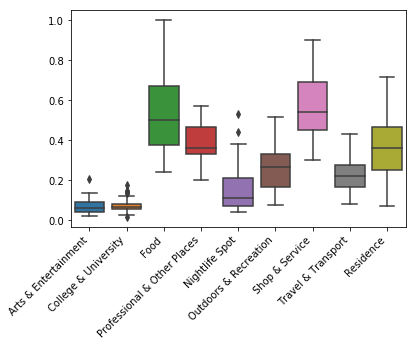

In [95]:
ax=sns.boxplot(data=berlin_grouped2.loc[berlin_grouped2['Cluster Labels']==0].drop(['Cluster Labels'], axis=1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')

#### Cluster 1 (purple)

In [81]:
print(result2.loc[result2['Cluster Labels']==1].shape)
result2.loc[result2['Cluster Labels']==1]

(26, 17)


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Event,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,Station Name,Line,Neighborhood,lon,lat
10,1,Bellevue,0.072165,0.053333,0.1,0.54,0.36,0.14,0.5125,0.49,0.34,0.214286,Bellevue,Stadtbahn,"Hansaviertel(Mitte)52° 31′ 12″ N, 13° 20′ 52″ O",52.520000,13.347778
16,1,Beusselstraße,0.061856,0.053333,0.1,0.60,0.35,0.10,0.1000,0.49,0.14,0.071429,Beusselstraße,Ringbahn,"Moabit(Mitte)52° 32′ 4″ N, 13° 19′ 46″ O",52.534444,13.329444
23,1,Bornholmer Straße,0.030928,0.133333,0.0,0.74,0.32,0.18,0.2625,0.65,0.27,0.500000,Bornholmer Straße,NordbahnStettiner Bahn,"Prenzlauer Berg(Pankow)52° 33′ 16″ N, 13° 23′ ...",52.554444,13.398056
27,1,Bundesplatz(bis 1938 Wilmersdorf-Friedenau)(19...,0.072165,0.053333,0.1,0.59,0.50,0.13,0.3000,0.50,0.22,0.285714,Bundesplatz(bis 1938 Wilmersdorf-Friedenau)(19...,Ringbahn,Wilmersdorf(Tempelhof-Schöneberg)52° 28′ 39″ N...,52.477500,13.328611
40,1,Friedenau,0.041237,0.066667,0.0,0.51,0.46,0.11,0.2125,0.52,0.21,0.571429,Friedenau,Wannseebahn,"Schöneberg(Tempelhof-Schöneberg)52° 28′ 12″ N,...",52.470000,13.340556
47,1,Gesundbrunnen,0.041237,0.053333,0.0,0.55,0.47,0.16,0.3375,0.73,0.29,0.642857,Gesundbrunnen,RingbahnStettiner Bahn,"Gesundbrunnen(Mitte)52° 32′ 55″ N, 13° 23′ 22″ O",52.548611,13.389444
48,1,Greifswalder Straße(bis 1946 Weißensee)(1986–1...,0.103093,0.080000,0.0,0.38,0.29,0.08,0.2500,0.54,0.14,0.357143,Greifswalder Straße(bis 1946 Weißensee)(1986–1...,Ringbahn,"Prenzlauer Berg(Pankow)52° 32′ 24″ N, 13° 26′ ...",52.540000,13.440556
54,1,Halensee,0.051546,0.040000,0.1,0.44,0.31,0.08,0.2500,0.60,0.25,0.428571,Halensee,Ringbahn,Halensee(Charlottenburg-Wilmersdorf)52° 29′ 46...,52.496111,13.290556
62,1,Hermannstraße,0.041237,0.000000,0.0,0.58,0.27,0.23,0.1625,0.56,0.17,0.642857,Hermannstraße,Ringbahn,"Neukölln(Neukölln)52° 28′ 3″ N, 13° 25′ 52″ O",52.467500,13.431111
70,1,Humboldthain,0.103093,0.146667,0.1,0.74,0.57,0.21,0.2875,0.78,0.28,0.285714,Humboldthain,Stettiner Bahn,"Gesundbrunnen(Mitte)52° 32′ 42″ N, 13° 22′ 46″ O",52.545000,13.379444


[Text(0, 0, 'Arts & Entertainment'),
 Text(0, 0, 'College & University'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Professional & Other Places'),
 Text(0, 0, 'Nightlife Spot'),
 Text(0, 0, 'Outdoors & Recreation'),
 Text(0, 0, 'Shop & Service'),
 Text(0, 0, 'Travel & Transport'),
 Text(0, 0, 'Residence')]

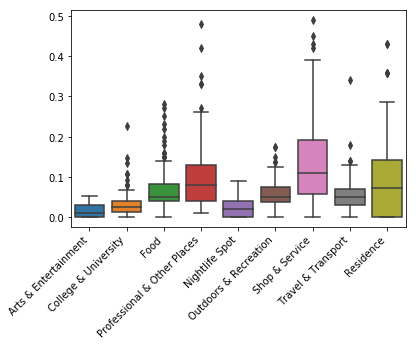

In [99]:
ax=sns.boxplot(data=berlin_grouped2.loc[berlin_grouped2['Cluster Labels']==1].drop(['Cluster Labels'], axis=1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')

#### Cluster 2 (green)

In [100]:
print(result2.loc[result2['Cluster Labels']==2].shape)
result2.loc[result2['Cluster Labels']==2]

(14, 16)


,Cluster Labels,Station Name,Arts & Entertainment,College & University,Food,Professional & Other Places,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Residence,Station Name,Line,Neighborhood,lon,lat
3,2,Alexanderplatz,0.618557,0.293333,1.00,0.72,0.70,0.8000,0.92,1.00,0.785714,Alexanderplatz,Stadtbahn,"Mitte(Mitte)52° 31′ 17″ N, 13° 24′ 43″ O",52.521389,13.411944
6,2,Anhalter Bahnhof,0.432990,0.240000,1.00,0.78,0.39,0.6750,0.92,0.85,0.357143,Anhalter Bahnhof,Anhalter BahnDresdener BahnNord-Süd-Tunnel,Kreuzberg(Friedrichshain-Kreuzberg)52° 30′ 11″...,52.503056,13.381944
24,2,Brandenburger Tor(bis 2009 Unter den Linden),0.587629,0.693333,1.00,1.00,0.60,0.7875,1.00,1.00,0.285714,Brandenburger Tor(bis 2009 Unter den Linden),Nord-Süd-Tunnel,"Mitte(Mitte)52° 30′ 59″ N, 13° 22′ 51″ O",52.516389,13.380833
28,2,Charlottenburg,0.051546,0.066667,1.00,0.46,0.32,0.4625,0.80,0.83,1.000000,Charlottenburg,StadtbahnWetzlarer Bahn,Charlottenburg(Charlottenburg-Wilmersdorf)52° ...,52.504722,13.303333
43,2,Friedrichstraße,0.824742,1.000000,1.00,0.99,0.90,0.8875,0.81,1.00,0.428571,Friedrichstraße,StadtbahnNord-Süd-Tunnel,"Mitte(Mitte)52° 31′ 13″ N, 13° 23′ 13″ O",52.520278,13.386944
53,2,Hackescher Markt(bis 1951 Börse)(1951–1992 Mar...,1.000000,0.813333,1.00,0.72,1.00,1.0000,0.88,1.00,0.714286,Hackescher Markt(bis 1951 Börse)(1951–1992 Mar...,Stadtbahn,"Mitte(Mitte)52° 31′ 21″ N, 13° 24′ 8″ O",52.522500,13.402222
55,2,Hauptbahnhof(bis 2002 Lehrter Stadtbahnhof)(20...,0.175258,0.280000,0.75,0.59,0.15,0.5000,0.66,0.67,0.785714,Hauptbahnhof(bis 2002 Lehrter Stadtbahnhof)(20...,Stadtbahn,"Moabit(Mitte)52° 31′ 30″ N, 13° 22′ 10″ O",52.525000,13.369444
91,2,Nordbahnhof(bis 1950: Stettiner Bahnhof),0.412371,0.573333,1.00,0.65,0.83,0.6625,0.65,0.77,0.785714,Nöldnerplatz(bis 1954 Neu-Lichtenberg),Ostbahn,"Rummelsburg(Lichtenberg)52° 30′ 14″ N, 13° 29′...",52.503889,13.485278
104,2,Potsdamer Bahnhof,0.546392,0.253333,1.00,0.80,0.44,0.6750,0.85,0.90,0.357143,Potsdam Hauptbahnhof(bis 1960 Potsdam)(1960–19...,Wannseebahn,"Potsdam52° 23′ 30″ N, 13° 4′ 0″ O",52.391667,13.066667
105,2,Prenzlauer Allee,0.226804,0.106667,1.00,0.57,0.69,0.4875,0.97,0.27,0.428571,Prenzlauer Allee,Ringbahn,"Prenzlauer Berg(Pankow)52° 32′ 41″ N, 13° 25′ ...",52.544722,13.426111


[Text(0, 0, 'Arts & Entertainment'),
 Text(0, 0, 'College & University'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Professional & Other Places'),
 Text(0, 0, 'Nightlife Spot'),
 Text(0, 0, 'Outdoors & Recreation'),
 Text(0, 0, 'Shop & Service'),
 Text(0, 0, 'Travel & Transport'),
 Text(0, 0, 'Residence')]

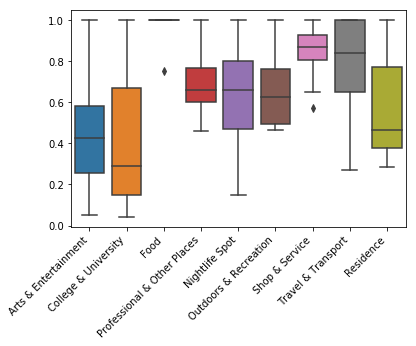

In [102]:
ax=sns.boxplot(data=berlin_grouped2.loc[berlin_grouped2['Cluster Labels']==2].drop(['Cluster Labels'], axis=1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right')